In [1]:
import os
import pickle
import json
from copy import deepcopy
import hashlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
from src.datajoint.datajoint_config import *

[2023-02-20 11:07:59,407][INFO]: Connecting pt1290@datajoint-tengel.pni.princeton.edu:3306
[2023-02-20 11:08:00,468][INFO]: Connected pt1290@datajoint-tengel.pni.princeton.edu:3306


In [2]:
rnn_dj  = RNNDJ()
task_dj  = TaskDJ()
trainer_dj  = TrainerDJ()

In [3]:
# trainer_dj.drop()
# task_dj.drop()
# rnn_dj.drop()

In [4]:
def jsonify(dct):
    dct_jsonified = {}
    for key in list(dct.keys()):
        if type(dct[key]) == type({}):
            dct_jsonified[key] = jsonify(dct[key])
        elif type(dct[key]) == np.ndarray:
            dct_jsonified[key] = dct[key].tolist()
        else:
            dct_jsonified[key] = dct[key]
    return dct_jsonified

def get_hash(dictionary):
    dictionary_json = json.dumps(dictionary, sort_keys=True).encode("utf-8")
    h = hashlib.md5(dictionary_json).hexdigest()[:16]
    return h

In [8]:
folder = os.path.join("../", 'data', 'trained_RNNs', 'CDDM')
subfolders = os.listdir(folder)
for subfolder in subfolders:
    if not subfolder.startswith('.'):
        if subfolder == 'exemplar_RNN':
            pass
        else:
            for file in list(os.listdir(os.path.join(folder, subfolder))):
                if 'params' in file:
                    score = file.split('_')[0]
                    taskname = "CDDM"
            print(subfolder)
            config_dict = json.load(open(os.path.join(folder, subfolder, f'{score}_config.json'), 'rb'))
            net_params_file = os.path.join(folder, subfolder, f'{score}_params_CDDM.pkl')
            net_params = pickle.load(open(net_params_file, 'rb'))

            LA_data_file = os.path.join(folder, subfolder, f'{score}_LA_data.pkl')
            LA_data_file_exists = os.path.exists(LA_data_file)
            LA_data = pickle.load(open(LA_data_file, 'rb')) if LA_data_file_exists else None

            fp_data_file = os.path.join(folder, subfolder, f'{score}_fp_data.pkl')
            fp_data_file_exists = os.path.exists(fp_data_file)
            fp_data = pickle.load(open(fp_data_file, 'rb')) if fp_data_file_exists else None

            psycho_data_file = os.path.join(folder, subfolder, f'{score}_psycho_data.pkl')
            psycho_data_file_exists = os.path.exists(fp_data_file)
            psycho_data = pickle.load(open(psycho_data_file, 'rb')) if psycho_data_file_exists else None

    #         if psycho_data is None: print('found no psycho_data file!') 
    #         if fp_data is None: print('found no fp_data file!') 
    #         if LA_data is None: print('found no LA_data file!') 

            if (psycho_data is None) or (fp_data is None) or (LA_data is None):
                pass # skip this entry
            else:
                rnn_dj = RNNDJ()
                task_dj = TaskDJ()
                trainer_dj = TrainerDJ()
                config_dict["task_params"]["seed"] = None
                task_dj_dict = {"task_name": taskname,
                                "n_steps": config_dict["n_steps"],
                                "n_inputs": config_dict["num_inputs"],
                                "n_outputs": config_dict["num_outputs"],
                                "task_params": config_dict["task_params"],
                                "mask": config_dict["mask"]}
                task_hash = get_hash(jsonify(task_dj_dict))
                task_dj_dict["task_hash"] = task_hash

                trainer_dj_dict = {"max_iter": config_dict["max_iter"],
                                   "tol": config_dict["tol"],
                                   "lr": config_dict["lr"],
                                   "lambda_orth": config_dict["lambda_orth"],
                                   "lambda_r": config_dict["lambda_r"],
                                   "same_batch" : config_dict["same_batch"],
                                   "shuffle" : False}
                trainer_hash = get_hash(jsonify(trainer_dj_dict))
                trainer_dj_dict["trainer_hash"] = trainer_hash

                rnn_dj_dict = {"task_name": taskname,
                               "mse_score": score,
                               "timestamp" : subfolder,
                               "n": config_dict["N"],
                               "activation_name": config_dict["activation"],
                               "constrained": config_dict["constrained"],
                               "dt": config_dict["dt"],
                               "tau": config_dict["tau"],
                               "sr": config_dict["sr"],
                               "connectivity_density_rec": config_dict["connectivity_density_rec"],
                               "sigma_rec" : config_dict["sigma_rec"],
                               "sigma_inp": config_dict["sigma_inp"],
                               "task_hash" : task_hash,
                               "trainer_hash": trainer_hash}
                rnn_dj_dict["w_inp"] = net_params["W_inp"]
                rnn_dj_dict["w_rec"] = net_params["W_rec"]
                rnn_dj_dict["w_out"] = net_params["W_out"]
                rnn_dj_dict["b_rec"] = 0 if net_params["bias_rec"] is None else net_params["bias_rec"]
                rnn_hash = get_hash(jsonify(rnn_dj_dict))
                rnn_dj_dict["rnn_hash"] = rnn_hash
                rnn_dj_dict["psycho_data"] = deepcopy(psycho_data)
                rnn_dj_dict["psycho_data"] = deepcopy(fp_data)
                rnn_dj_dict["la_data"] = deepcopy(LA_data)


                task_dj.insert1(task_dj_dict, skip_duplicates=True)
                trainer_dj.insert1(trainer_dj_dict, skip_duplicates=True)
                rnn_dj.insert1(rnn_dj_dict, skip_duplicates=True)
                print(f"successfully created new entry!")

20230201-02340922
successfully created new entry!
20230201-23004032
successfully created new entry!
20230202-02112786
successfully created new entry!
20230201-13113671
20230206-22563968
successfully created new entry!
20230131-2038343
successfully created new entry!
20230201-23030238
successfully created new entry!
20230207-03414135
successfully created new entry!
20230202-02120688
successfully created new entry!
20230131-23492770
successfully created new entry!
20230201-10135611
successfully created new entry!
20230207-06170372
successfully created new entry!
20230201-10230514
successfully created new entry!
20230202-02131390
successfully created new entry!
20230202-1103494
successfully created new entry!
20230206-2319035
successfully created new entry!
20230207-04435454
successfully created new entry!
20230202-15211568
successfully created new entry!
20230201-03025237
successfully created new entry!
20230207-02520528
successfully created new entry!
20230206-20522139
successfully crea

successfully created new entry!
20230202-14471755
successfully created new entry!
20230202-02173896
successfully created new entry!
20230201-03455267
successfully created new entry!
20230201-1012475
successfully created new entry!
20230207-01450398
successfully created new entry!
20230202-16375377
successfully created new entry!
20230202-1103506
successfully created new entry!
20230207-04093538
successfully created new entry!
20230202-14491358
successfully created new entry!
20230207-03063132
successfully created new entry!
20230201-14505298
successfully created new entry!
20230201-13062066
20230202-17403898
successfully created new entry!
20230202-02074783
successfully created new entry!
20230202-14491360
successfully created new entry!
20230207-01043594
successfully created new entry!
20230131-1833362
successfully created new entry!
20230202-02040779
successfully created new entry!
20230201-01045884
successfully created new entry!
20230202-00421374
successfully created new entry!
202

successfully created new entry!
20230201-04341798
successfully created new entry!
20230201-23080348
successfully created new entry!
20230131-22123738
successfully created new entry!
20230206-1837494
successfully created new entry!
20230201-11290339
successfully created new entry!
20230207-00344778
successfully created new entry!
20230201-23045044
successfully created new entry!
20230201-02243012
successfully created new entry!
20230207-06251277
successfully created new entry!
20230207-00252377
successfully created new entry!
20230201-10325325
successfully created new entry!
20230202-02054080
successfully created new entry!
20230201-13352179
successfully created new entry!
20230202-00370859
20230206-20491133
successfully created new entry!
20230201-14475397
successfully created new entry!
20230202-00385366
successfully created new entry!
20230202-13381250
successfully created new entry!
20230131-23304351
successfully created new entry!
20230218-16384234
successfully created new entry!
2

successfully created new entry!
20230202-11053213
successfully created new entry!
20230202-00322553
successfully created new entry!
20230206-22362453
successfully created new entry!
20230202-13035439
successfully created new entry!
20230202-00322554
successfully created new entry!
20230202-11053214
successfully created new entry!
20230206-19012622
successfully created new entry!
20230201-02531332
successfully created new entry!
20230201-04200788
successfully created new entry!
20230131-20435011
successfully created new entry!
20230202-01311078
20230131-23315152
successfully created new entry!
20230207-00492386
successfully created new entry!
20230201-14380793
successfully created new entry!
20230201-04254493
successfully created new entry!
20230131-20485518
successfully created new entry!
20230131-23510772
successfully created new entry!
20230207-04323250
successfully created new entry!
20230202-16390280
successfully created new entry!
20230202-02165995
successfully created new entry!


successfully created new entry!
20230202-1104209
successfully created new entry!
20230202-00480677
successfully created new entry!
20230202-16421585
successfully created new entry!
20230201-03191852
successfully created new entry!
20230131-20495821
successfully created new entry!
20230207-06004365
successfully created new entry!
20230201-03565276
successfully created new entry!
20230207-07184481
successfully created new entry!
20230131-20474514
successfully created new entry!
20230202-1103272
successfully created new entry!
20230207-07534788
successfully created new entry!
20230202-16553289
successfully created new entry!
20230207-0103197
successfully created new entry!
20230207-00514590
successfully created new entry!
20230201-21275317
successfully created new entry!
20230202-11055616
successfully created new entry!
20230201-12265355
successfully created new entry!
20230206-22552666
successfully created new entry!
20230202-12584731
successfully created new entry!
20230206-21184849
suc

In [9]:
(rnn_dj & 'activation_name="relu"')

task_hash,trainer_hash,rnn_hash unique model id,mse_score,task_name,timestamp,n number of nodes in the RNN,activation_name name of the activation function used in the dynamics,"constrained boolean variable, either True or False, using biologically plausible connectivity or not",dt Euler integration timestep,tau Dynamical time-scale,sr spectral radius of the recurrent conenctivity,connectivity_density_rec opposite of sparsity of the connectivity. 1 - fully connected network,sigma_rec,sigma_inp,w_inp,w_rec,w_out,b_rec,fp_data,psycho_data,la_data
3c208c803319143c,325c235ec6a23a8c,009b2b83eb8fa5f1,0.0009194,CDDM,20230202-02165995,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,0303a1594328fc23,0.0009194,CDDM,20230202-02071781,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,06327d1ebe0adad3,0.0009194,CDDM,20230201-23015335,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,09e4109446a8c923,0.0009194,CDDM,20230201-23080349,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,0dec3c66e74606dd,0.0003487,CDDM,20230201-23291750,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,0ef69ca7c3bc19c7,0.0009194,CDDM,20230201-23004031,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,144c088b77dfe7bc,0.0003487,CDDM,20230202-02162994,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,1cee2bf5c944c37a,0.0009194,CDDM,20230201-23030238,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,2097a2def1b2e614,0.0009194,CDDM,20230202-00462776,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,21aac09a09b3affe,0.0009194,CDDM,20230202-02144693,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [11]:
subdata = pd.DataFrame((rnn_dj & 'activation_name="relu"').fetch("rnn_hash", "timestamp", "trainer_hash", "mse_score", order_by='mse_score'))
with pd.option_context('display.max_rows', None,):
    print(subdata)

                 0                  1                  2                  3    \
0   a0faebbdf4877c9e   c9146610c290f84d   6c434099cd628a2f   cc3244ce46188d95   
1  20230207-05123657  20230207-07570091  20230206-23461075  20230207-02202313   
2   c09f5b4d11538512   c09f5b4d11538512   c09f5b4d11538512   c09f5b4d11538512   
3           0.000113           0.000113           0.000113           0.000113   

                 4                  5                  6                  7    \
0   ccc11483cce57f79   cd4749c67581689b   341f9942add28563   95edcfaeec307a70   
1  20230207-06132271  20230207-05235458  20230207-03083533  20230207-04274446   
2   c09f5b4d11538512   c09f5b4d11538512   c09f5b4d11538512   c09f5b4d11538512   
3           0.000113           0.000113           0.000113           0.000113   

                 8                   9    ...                521  \
0   5334ba25753e5c53    d54be2cbc1f6743c  ...   b78e238b9af4f58d   
1  20230207-03414135  20230207-020135100  ...  20230

In [12]:
mse_scores = pd.DataFrame((rnn_dj & 'activation_name="relu"').fetch("mse_score", order_by="mse_score"))

(array([146.,  13., 170.,  18.,  98.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  85.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.0001133 , 0.00017362, 0.00023394, 0.00029427, 0.00035459,
        0.00041491, 0.00047523, 0.00053555, 0.00059588, 0.0006562 ,
        0.00071652, 0.00077684, 0.00083716, 0.00089749, 0.00095781,
        0.00101813, 0.00107845, 0.00113877, 0.0011991 , 0.00125942,
        0.00131974, 0.00138006, 0.00144038, 0.00150071, 0.00156103,
        0.00162135, 0.00168167, 0.00174199, 0.00180232, 0.00186264,
        0.00192296, 0.00198328, 0.0020436 , 0.00210393, 0.00216425,
        0.00222457, 0.00228489, 0.00234521, 0.00240554, 0.00246586,
        0.00252618, 0.0025865 , 0.00264682, 0.00270715, 0.00276747,
        0.00282779, 0.00288811, 0.00294843, 0.

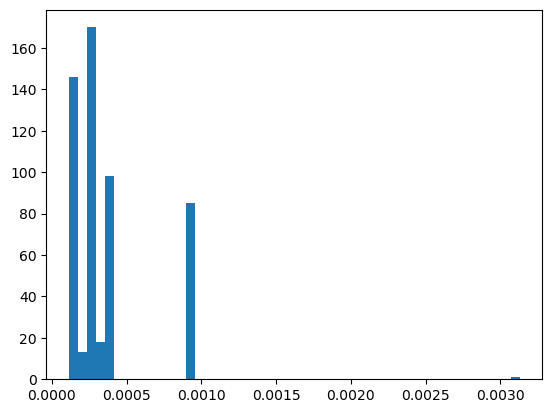

In [13]:
from matplotlib import pyplot as plt
plt.hist(mse_scores, bins = 50)

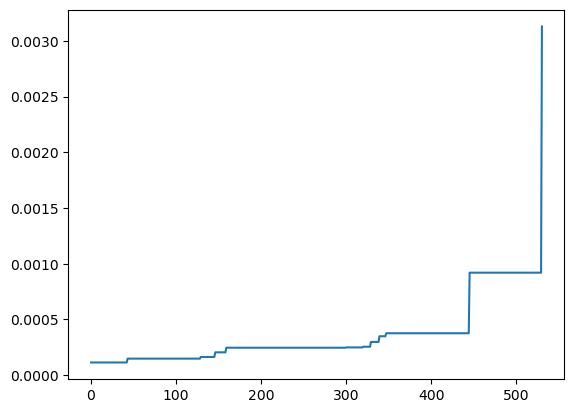

In [14]:
plt.plot(mse_scores)

In [15]:
mse_scores[:50]

,0
0,0.000113
1,0.000113
2,0.000113
3,0.000113
4,0.000113
5,0.000113
6,0.000113
7,0.000113
8,0.000113
9,0.000113
